In [27]:
import matplotlib.pyplot as plt
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from plotly import tools
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
from sklearn.utils.multiclass import unique_labels

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Initialize notebook mode to display plots using plotly library
init_notebook_mode(connected=True)

## Read data from csv file

In [3]:
columns = ["Sepal length", "Sepal width", "Petal length", "Petal width", "Class"]
dataframe = pd.read_csv("./iris_data.csv", names=columns)

dataframe.head()

,Sepal length,Sepal width,Petal length,Petal width,Class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


## Slice dataframe into 3 pieces

In [4]:
iris_setosa_df = dataframe[:50]
iris_versicoulour_df = dataframe[50:100]
iris_virginica_df = dataframe[100:]

## Data Visualisation

In [5]:
traces = []
colors = ["blue", "green", "yellow"]
for counter, col in enumerate(columns[:-1]):
    for i, color in zip(range(0, 150, 50), colors):
        traces.append(
            go.Scatter(
                x=np.linspace(1, 50),
                y=dataframe[i:i+50][col],
                legendgroup=dataframe.iloc[i]["Class"],
                name=dataframe.iloc[i]["Class"],
                mode="lines+markers",
                line=dict(
                    color=color
                ),
                showlegend=False
            )
        )

fig = tools.make_subplots(rows=2, cols=2, subplot_titles=columns[:-1])
coords = (
    (1, 1),
    (1, 2),
    (2, 1),
    (2, 2)
)
for cord, i in zip(coords, range(4)):
    for c in range(3):
        fig.append_trace(traces[i + c], cord[0], cord[1])
# dir(fig.layout)
fig['layout'].update(
    title='Data Comparision beetween Iris classes',
)
iplot(fig, filename='make-subplots-multiple-with-titles')


This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]



## Creating two datasets for training and testing

In [6]:
train_set = pd.concat([dataframe[i:i+50].sample(40) for i in range(0, 150, 50)])
test_set = pd.concat([dataframe, train_set]).drop_duplicates(keep=False)

## Creating labels for training and test datasets

In [7]:
train_labels, train_set = train_set[["Class"]], train_set[dataframe.columns[:4]]
test_labels, test_set = test_set[["Class"]], test_set[dataframe.columns[:4]]

## Conversion categorical data to numbers

In [8]:
train_labels["Class"] = pd.Categorical(train_labels["Class"])
train_labels["Class"] = train_labels["Class"].cat.codes

test_labels["Class"] = pd.Categorical(test_labels["Class"])
test_labels["Class"] = test_labels["Class"].cat.codes

## Training model using Linear Regression

In [9]:
model = LinearRegression()
model.fit(train_set, train_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

## Results

In [10]:
predict = model.predict(test_set)
print('Coefficients: ', model.coef_)
# The mean squared error
print("Mean squared error: {:.2f}".format(mean_squared_error(test_labels, predict)))
# Explained variance score: 1 is perfect prediction
print('Variance score: {:.2f}'.format(r2_score(test_labels, predict)))

Coefficients:  [[-0.06736255 -0.08470321  0.17712624  0.6795322 ]]
Mean squared error: 0.04
Variance score: 0.94


## Classification

In [24]:
classifier = SVC(kernel='linear', C=0.01)
y_pred = classifier.fit(train_set, train_labels.values.ravel()).predict(test_set)

In [25]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 1, 2, 2, 2, 2], dtype=int8)

## Confusion Matrix

In [26]:
confusion_matrix(test_labels, y_pred)

array([[10,  0,  0],
       [ 0, 10,  0],
       [ 0,  1,  9]])

In [28]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [30]:
np.set_printoptions(precision=2)

### Not Normalized Confusion Matrix

Confusion matrix, without normalization
[[10  0  0]
 [ 0 10  0]
 [ 0  1  9]]


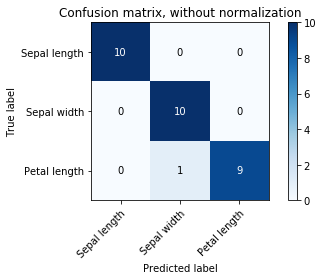

In [36]:
plot_confusion_matrix(test_labels, y_pred, classes=np.asarray(columns),
                      title='Confusion matrix, without normalization')

### Normalized Confusion Matrix 

Normalized confusion matrix
[[1.  0.  0. ]
 [0.  1.  0. ]
 [0.  0.1 0.9]]


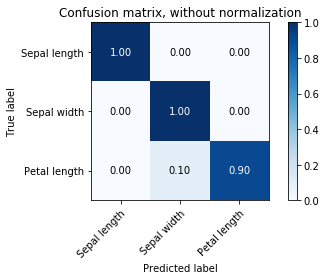

In [38]:
plot_confusion_matrix(test_labels, y_pred, classes=np.asarray(columns),
                      title='Confusion matrix, without normalization', normalize=True)